In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import mlflow
import os

from sklearn.metrics import r2_score, mean_squared_error
from src.utils import get_metrics

from presentation.pipelines.steps.model_design import load_pt_model
from presentation.pipelines.steps.load_data import build_loader 


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-03-14 12:18:52.310378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Pretraining

In [3]:
root = './presentation/results/comparison/2024-03-14_01-31-31/'

astromer, config = load_pt_model(os.path.join(root, 'pretraining'))

[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-03-14 12:18:58.252059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-14 12:18:58.252116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 25a279091118
2024-03-14 12:18:58.252131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 25a279091118
2024-03-14 12:18:58.252349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-03-14 12:18:58.252385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.5
2024-03-14 12:18:58.253318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


In [4]:
pd.DataFrame(config, index=[0])[['arch', 'mask_format', 'm_alpha', 'probed', 'rs', 'same', 'scheduler']]

,arch,mask_format,m_alpha,probed,rs,same,scheduler
0,base,QK,1.0,0.9,0.0,0.0,True


In [5]:
data_path = './data/records/macho/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=32,
                       clf_mode=False,
                       sampling=True)

[INFO] Probed: 0.90 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking
[INFO] Probed: 0.90 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking
[INFO] Probed: 0.90 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking


In [6]:
output = astromer.predict(loaders['test'].take(10))

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['mask_out'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
10/10 [==============================] - 3s 157ms/step


In [7]:
output['magnitudes'].shape, output['reconstruction'].shape, output['probed_mask'].shape

((320, 200, 1), (320, 200, 1), (320, 200, 1))

In [8]:
y = tf.ragged.boolean_mask(output['magnitudes'], output['probed_mask'])
y_hat = tf.ragged.boolean_mask(output['reconstruction'], output['probed_mask'])

In [9]:
r2_values = []
mse_values = []
for i in range(output['magnitudes'].shape[0]):
    y = tf.boolean_mask(output['magnitudes'][i], output['probed_mask'][i])
    y_hat = tf.boolean_mask(output['reconstruction'][i], output['probed_mask'][i])
    r2_values.append(r2_score(y, y_hat))
    mse_values.append(mean_squared_error(y, y_hat, squared=False))

In [10]:
test_r2   = np.mean(r2_values) 
test_mse = np.mean(mse_values)

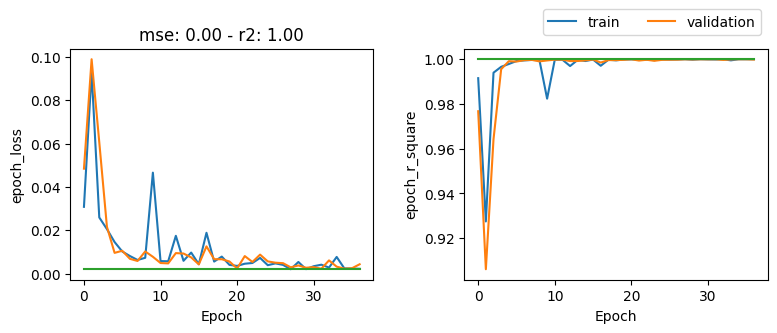

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'wspace':0.3})

for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
    train_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'train'), 
                                metric_name=metric_name)
    valid_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'validation'), 
                                metric_name=metric_name)
    axes[i].plot(train_metrics['step'], train_metrics['value'], label='train')
    axes[i].plot(valid_metrics['step'], valid_metrics['value'], label='validation')
    
    if metric_name == 'epoch_r_square':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_r2, test_r2])
    if metric_name == 'epoch_loss':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_mse, test_mse])
        
    axes[i].set_ylabel(metric_name)
    axes[i].set_xlabel('Epoch')
    
axes[0].set_title('mse: {:.2f} - r2: {:.2f}'.format(test_mse, test_r2))
axes[-1].legend(bbox_to_anchor=(1., 1.2), ncols=2)
plt.show()

Text(0.5, 1.0, 'True vs Predicted')

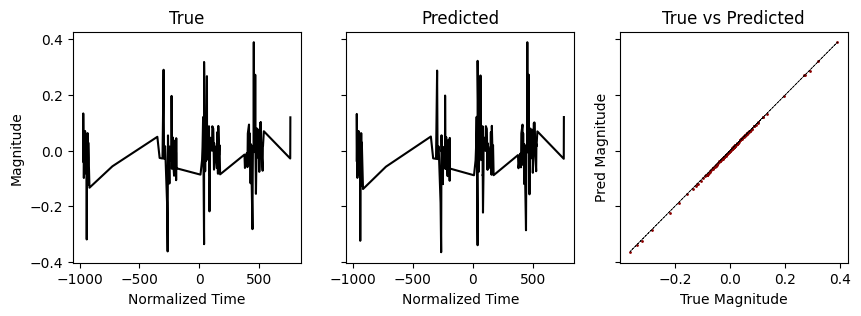

In [12]:
N = 1

x_true = tf.boolean_mask(output['magnitudes'][N], output['probed_mask'][N])
x_pred = tf.boolean_mask(output['reconstruction'][N], output['probed_mask'][N])
times = tf.boolean_mask(output['times'][N], output['probed_mask'][N])

fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.2}, sharey=True)
axes[0].plot(times, x_true, color='k', label='True')
axes[0].set_title('True')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlabel('Normalized Time')
axes[1].plot(times, x_pred, color='k', label='Prediction')
axes[1].set_title('Predicted')
axes[1].set_xlabel('Normalized Time')
axes[2].scatter(x_true, x_pred, s=1, color='darkred')
axes[2].plot(x_true, x_true, linewidth=0.5, color='k', linestyle='--')

axes[2].set_xlabel('True Magnitude')
axes[2].set_ylabel('Pred Magnitude')
axes[2].set_title('True vs Predicted')

## Finetunem (MLFlow)

In [7]:
runs_df = mlflow.search_runs(experiment_ids=['128374866685660472'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']
runs_df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.loss', 'metrics.validation_loss', 'metrics.rmse',
       'metrics.validation_r_square', 'metrics.val_r_square',
       'metrics.test_rmse', 'metrics.validation_rmse', 'metrics.val_rmse',
       'metrics.test_r2', 'metrics.test_loss', 'metrics.val_loss',
       'metrics.r_square', 'params.optimizer_global_clipnorm',
       'params.optimizer_jit_compile', 'params.optimizer_amsgrad',
       'params.optimizer_clipnorm', 'params.optimizer_ema_momentum',
       'params.optimizer_learning_rate', 'params.optimizer_weight_decay',
       'params.optimizer_clipvalue', 'params.optimizer_name',
       'params.optimizer_is_legacy_optimizer', 'params.optimizer_beta_2',
       'params.optimizer_ema_overwrite_frequency', 'params.optimizer_use_ema',
       'params.optimizer_epsilon', 'params.optimizer_beta_1',
       'tags.num_layers', 'tags.pe_exp', 'tags.fold', 'tags.probed',
       'tags.debug', 'tag

In [5]:
id_cols = ['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']
    
selected = runs_df[id_cols+['tags.fold', 'metrics.val_rmse', 'metrics.test_r2']]

selected.groupby(id_cols).agg({'metrics.val_rmse': ['mean', 'std'],
                                                                          'metrics.test_r2': ['mean', 'std']})

metrics.val_rmse  \
                                                                                                mean   
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc                    
atlas                base      -1000000000.0 0.5         0.0     0.4       100              0.124856   
                                                                           20               0.137506   
                                                                           500              0.102649   
                               1.0           0.5         0.2     0.2       100              0.223426   
                                                                           20               0.271658   
                                                                           500              0.114172   
macho                base      -1000000000.0 0.5         0.0     0.4       100              0.079102   
                                                                           20               0.053448   
                                                                           500              0.087468   
                               1.0           0.5         0.2     0.2       100              0.132956   
                                                                           20               0.093864   
                                                                           500              0.133236   

                                                                                               \
                                                                                          std   
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc             
atlas                base      -1000000000.0 0.5         0.0     0.4       100       0.011952   
                                                                           20        0.011734   
                                                                           500       0.027516   
                               1.0           0.5         0.2     0.2       100       0.019081   
                                                                           20        0.070992   
                                                                           500       0.038058   
macho                base      -1000000000.0 0.5         0.0     0.4       100       0.014848   
                                                                           20        0.004282   
                                                                           500       0.010329   
                               1.0           0.5         0.2     0.2       100       0.021965   
                                                                           20        0.008605   
                                                                           500       0.019977   

                                                                                    metrics.test_r2  \
                                                                                               mean   
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc                   
atlas                base      -1000000000.0 0.5         0.0     0.4       100             0.779488   
                                                                           20              0.759764   
                                                                           500             0.702625   
                               1.0           0.5         0.2     0.2       100             0.698525   
                                                                           20              0.600729   
                                                                           500             0.666872   
macho                base      -1000000000.0 0.5         0.0     0.4       100             0.863411   
                                     

## Classification (MLFlow)

In [139]:
runs_df = mlflow.search_runs(experiment_ids=['852161655664768094'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']

runs_df = runs_df[['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 
                   'tags.probed', 'tags.rs', 'tags.same', 'tags.spc', 
                   'tags.fold', 'metrics.test_f1']]
runs_df['tags.fold'] = runs_df['tags.fold'].astype(float)
runs_df['metrics.test_f1'] = runs_df['metrics.test_f1'].astype(float)

In [140]:
runs_df.groupby(['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 
                 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']).agg({'metrics.test_f1': ['mean', 'std']})

metrics.test_f1  \
                                                                                              mean   
tags.downstream_data tags.arch tags.m_alpha tags.probed tags.rs tags.same tags.spc                   
atlas                base      1.0          0.5         0.2     0.8       100             0.565016   
                                                                          20              0.585054   
                                                                          500             0.651385   
macho                base      1.0          0.5         0.2     0.8       100             0.575650   
                                                                          20              0.233617   
                                                                          500             0.618645   

                                                                                              
                                                                                         std  
tags.downstream_data tags.arch tags.m_alpha tags.probed tags.rs tags.same tags.spc            
atlas                base      1.0          0.5         0.2     0.8       100       0.165939  
                                                                          20        0.076211  
                                                                          500       0.052051  
macho                base      1.0          0.5         0.2     0.8       100       0.039289  
                                                                          20        0.274173  
                                                                          500       0.003478